# Working with Cuts in Lhotse

This notebooks goes over Cut and CutSet classes in Lhotse, and demonstrates some of their functionality. 

Cuts help to reshape, transform, and interact with audio data. Think of them as tracks that you see in DAW software such as Audacity. Typical operations on cuts/cutsets are truncation, padding, mixing with other cuts, as well as performing data augmentation that requires to adjust the supervision data (e.g., when perturbing speed, you might also want to adjust the time markers for the transcription segment).

In [1]:
# Optional auto-formatting

#!pip install nb_black
%load_ext lab_black

In [2]:
import os
from pathlib import Path
from pprint import pprint
from dataclasses import asdict

from lhotse import load_manifest, CutSet, SupervisionSegment, Mfcc, Fbank, Spectrogram
from lhotse.recipes import download_librispeech, prepare_librispeech

In [3]:
root_dir = Path("data")
tmp_dir = Path("tmp")
tmp_dir.mkdir(exist_ok=True)
num_jobs = os.cpu_count() - 1

# (mini) LibriSpeech

We're downloading the data, preparing recording/supervision manfiests, and compiling them into CutSets. 
A cut is a basic "example" of data in Lhotse.

Approx. download size 450MB.

In [4]:
# libri_variant = "librispeech"
libri_variant = "mini_librispeech"
libri_root = download_librispeech(root_dir, dataset_parts=libri_variant)
libri = prepare_librispeech(
    libri_root, dataset_parts=libri_variant, output_dir=root_dir, num_jobs=num_jobs
)
cuts_train = CutSet.from_manifests(**libri["train-clean-5"])
cuts_dev = CutSet.from_manifests(**libri["dev-clean-2"])

Dataset parts:   0%|          | 0/2 [00:00<?, ?it/s]

# Trimming to supervisions

Speech datasets come in two flavours: isolated utterances (e.g., LibriSpeech, MLS, most TTS datasets) and long recording sessions (e.g., GigaSpeech, TED, AMI, many telephonic speech datasets). 

For long recordings, you typically want to "segment" them into shorter fragments. For many use-cases it works to simply convert them to isolated utterances. Lhotse provides a function for this: `CutSet.trim_to_supervisions()`. Let's see it in action on an example where we add padding to LibriSpeech cut, and then trim it.

First, we select a cut, pad it, and visualize it.

<AxesSubplot:>

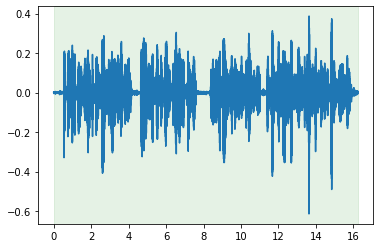

In [5]:
cut = cuts_train[0]
cut.plot_audio()

Then, we pad the cut from both sides (asymetrically) and visualize again.

<AxesSubplot:>

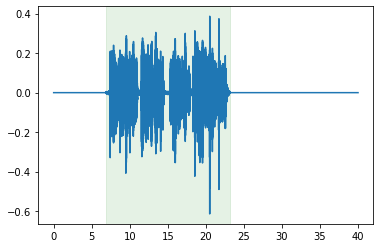

In [6]:
cut_pad = cut.pad(30, direction="both").pad(40, direction="right")
cut_pad.plot_audio()

Notice the green area -- it's a supervision segment, i.e. indicates which part of the cut contains some supervision (here, a transcript). We'll trim the cut to supervised regions now.

In [7]:
cut_pad_trim = cut_pad.trim_to_supervisions()
print(type(cut_pad_trim))

<class 'list'>


The result is a list of smaller cuts referring to supervised areas (if there are more than one). Let's plot the first (and only) one for this example:

<AxesSubplot:>

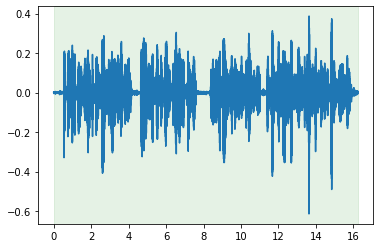

In [8]:
cut_pad_trim[0].plot_audio()

# Cutting manifests into fixed size windows

For some applications (VAD, diarization) it's useful to split a `CutSet` into fixed-size windows. Lhotse provides a function for this: `CutSet.cut_into_windows()`.

While we cut into windows, there will be some remainders and waveforms shorter than required duration. They will be present in the output, and can be filtered out with a custom predicate using `CutSet.filter()`.

In [9]:
wcs = cuts_train.cut_into_windows(5).filter(lambda cut: cut.duration == 5)

In [10]:
cut = wcs[0]

<AxesSubplot:>

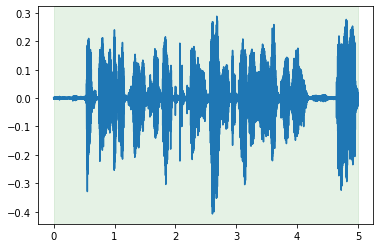

In [11]:
cut.plot_audio()

# Text representation of cuts

Cuts are regular Python classes, and they can be printed out to see the complete meta-data. We can also convert them to dicts (e.g., for disk serialization).

In [12]:
cut

MonoCut(id='5ff2b7e1-16ee-4e64-bd78-c48ead378216', start=0, duration=5, channel=0, supervisions=[SupervisionSegment(id='32-21631-0000', recording_id='32-21631-0000', start=0.0, duration=16.25, channel=0, text='AFTER MISTER CROW FLEW BACK TO PLEASANT VALLEY TO GATHER NEWS FOR HIM BROWNIE BEAVER CAREFULLY COUNTED EACH DAY THAT PASSED SINCE MISTER CROW HAD AGREED TO BE HIS NEWSPAPER AND COME EACH SATURDAY AFTERNOON TO TELL HIM EVERYTHING THAT HAD HAPPENED DURING THE WEEK', language='English', speaker='32', gender=None, custom=None, alignment=None)], features=None, recording=Recording(id='32-21631-0000', sources=[AudioSource(type='file', channels=[0], source='data/LibriSpeech/train-clean-5/32/21631/32-21631-0000.flac')], sampling_rate=16000, num_samples=260000, duration=16.25, transforms=None), custom=None)

In [13]:
pprint(asdict(cut))

{'channel': 0,
 'custom': None,
 'duration': 5,
 'features': None,
 'id': '5ff2b7e1-16ee-4e64-bd78-c48ead378216',
 'recording': {'duration': 16.25,
               'id': '32-21631-0000',
               'num_samples': 260000,
               'sampling_rate': 16000,
               'sources': [{'channels': [0],
                            'source': 'data/LibriSpeech/train-clean-5/32/21631/32-21631-0000.flac',
                            'type': 'file'}],
               'transforms': None},
 'start': 0,
 'supervisions': [{'alignment': None,
                   'channel': 0,
                   'custom': None,
                   'duration': 16.25,
                   'gender': None,
                   'id': '32-21631-0000',
                   'language': 'English',
                   'recording_id': '32-21631-0000',
                   'speaker': '32',
                   'start': 0.0,
                   'text': 'AFTER MISTER CROW FLEW BACK TO PLEASANT VALLEY TO '
                           'GATHE

# Extracting features from a cut

When working with slow disks, it's preferable to precompute the features for your data for faster reading during training. Lhotse's function for this is `CutSet.compute_and_store_features`.

Here, we show an example that computes default `Fbank` features for mini LibriSpeech training data. The operation doesn't modify the input cuts, and instead returns a new CutSet that contains the feature information.

Extracting and storing features (chunks progress):   0%|          | 0/9 [00:00<?, ?it/s]

{'channel': 0,
 'duration': 13.9,
 'features': {'channels': 0,
              'duration': 13.9,
              'frame_shift': 0.01,
              'num_features': 80,
              'num_frames': 1390,
              'sampling_rate': 16000,
              'start': 0,
              'storage_key': '0,45892,45678,35935',
              'storage_path': 'tmp/feats-train/feats-0.lca',
              'storage_type': 'lilcom_chunky',
              'type': 'kaldi-fbank'},
 'id': '7367-86737-0057-1082-0',
 'recording': {'duration': 13.9,
               'id': '7367-86737-0057',
               'num_samples': 222400,
               'sampling_rate': 16000,
               'sources': [{'channels': [0],
                            'source': 'data/LibriSpeech/train-clean-5/7367/86737/7367-86737-0057.flac',
                            'type': 'file'}]},
 'start': 0,
 'supervisions': [{'channel': 0,
                   'duration': 13.9,
                   'id': '7367-86737-0057',
                   'language': 'En

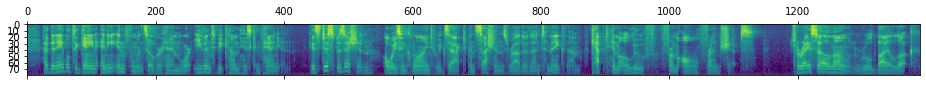

In [14]:
cuts_train = cuts_train.compute_and_store_features(
    Fbank(), "tmp/feats-train", num_jobs=num_jobs
)
cut = cuts_train[0]
pprint(cut.to_dict())
cut.plot_features()

# Data exploration - listening to and visualizing audio

In addition to plotting, we also enable listening to the audio in Jupyter notebooks.

<AxesSubplot:>

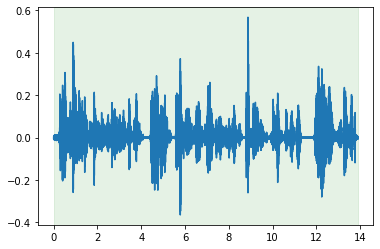

In [15]:
cut.plot_audio()

In [16]:
cut.play_audio()

# Mixing a cut + visualization

You can create your own data by mixing and appending cuts from different sources.

In [17]:
mixed = cuts_train[0].mix(
    # Note: we truncate the other cut to preserve the original duration
    cuts_train[1].truncate(duration=cuts_train[0].duration),
    snr=15,
)

<AxesSubplot:>

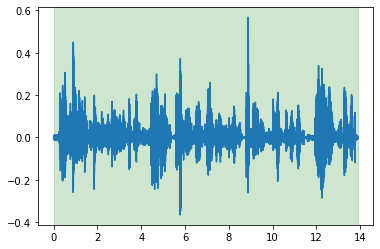

In [18]:
mixed.plot_audio()

In [19]:
mixed.play_audio()

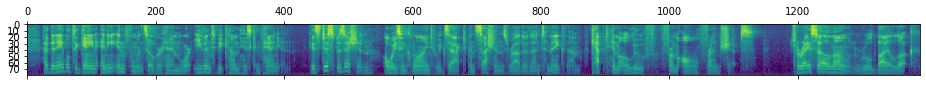

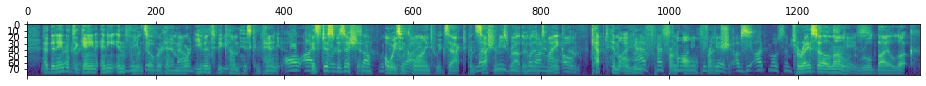

In [20]:
cuts_train[0].plot_features()
mixed.plot_features()

In [21]:
pprint(asdict(mixed))

{'id': 'a55a762a-d6ca-4e70-a030-63058de22c10',
 'tracks': [{'cut': {'channel': 0,
                     'custom': None,
                     'duration': 13.9,
                     'features': {'channels': 0,
                                  'duration': 13.9,
                                  'frame_shift': 0.01,
                                  'num_features': 80,
                                  'num_frames': 1390,
                                  'recording_id': None,
                                  'sampling_rate': 16000,
                                  'start': 0,
                                  'storage_key': '0,45892,45678,35935',
                                  'storage_path': 'tmp/feats-train/feats-0.lca',
                                  'storage_type': 'lilcom_chunky',
                                  'type': 'kaldi-fbank'},
                     'id': '7367-86737-0057-1082-0',
                     'recording': {'duration': 13.9,
                                  

# Appending two cuts

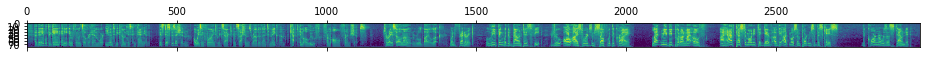

In [22]:
cuts_train[0].append(cuts_train[1]).plot_features()

# Cut-level data augmentation

We support some data augmentation transforms on Cuts -- they are triggered lazily upon loading the audio data. Some examples with speed perturbation and resampling are below.

Note: there are more transforms in Lhotse that we apply once we load cut data into tensors, e.g. SpecAugment.

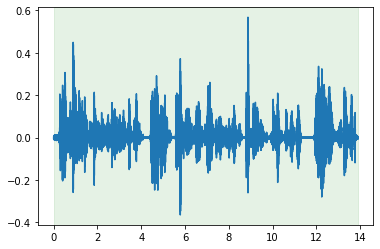

In [23]:
cut.plot_audio()
cut.play_audio()

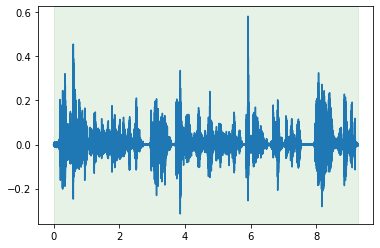

In [24]:
cut.perturb_speed(1.5).plot_audio()  # notice differences in the x-axis
cut.perturb_speed(1.5).play_audio()

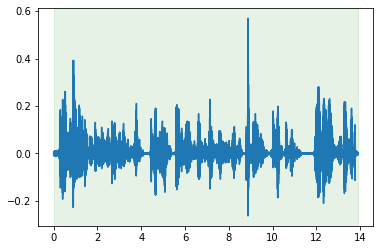

In [25]:
cut.resample(8000).plot_audio()
cut.resample(8000).play_audio()

The audio after mixing and augmentation can be saved to disk, see example:

In [26]:
cut_demo = (
    cut.perturb_speed(1.1)
    .mix(
        cuts_train[1].perturb_speed(0.9),
        snr=10,
    )
    .resample(8000)
    .truncate(duration=3.0)
    .save_audio("tmp/demo.wav")
)

In [27]:
cut_demo.recording.sources[0]

AudioSource(type='file', channels=[0], source='tmp/demo.wav')

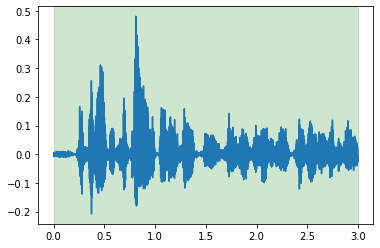

In [28]:
cut_demo.plot_audio()
cut_demo.play_audio()